In [1]:
using JuMP
using Gurobi, Ipopt
using Plots
using DataFrames
using CSV
using DelimitedFiles

In [2]:
function bicycle_model(state, input, dt, L)
    x, y, psi, v = state
    delta, a = input

    x_new = x + v * cos(psi) * dt
    y_new = y + v * sin(psi) * dt
    psi_new = psi + (v * tan(delta) / L) * dt
    v_new = v + a * dt

    return [x_new, y_new, psi_new, v_new]
end


bicycle_model (generic function with 1 method)

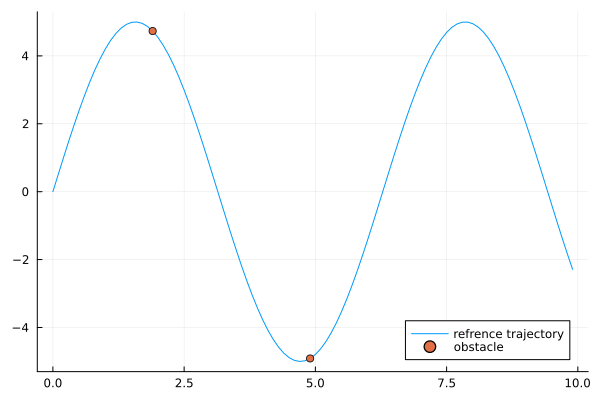

In [206]:
function reference_trajectory_gen(t)
    r = 2
    x_ref = t
    y_ref = 5sin(t)
    psi_ref = atan(cos(t))
    v_ref = 1.0
    return [x_ref, y_ref, psi_ref, v_ref]
end

len = 210
t = range(0,step=0.1,length=len)
ref_traj = Matrix{Float64}(undef, len,4)
for (i,t) in enumerate(t)
    ref_traj[i,:] = reference_trajectory_gen(t)
end
ref_x = ref_traj[:,1]
ref_y = ref_traj[:,2]
ref_psi = ref_traj[:,3]
ref_v = ref_traj[:,4]
N = len
plot(ref_x[1:100],ref_y[1:100], label="refrence trajectory")

obstacles = [ref_x[50] ref_y[50] 0.2;
             ref_x[20] ref_y[20] 0.2]
scatter!(obstacles[:,1], obstacles[:,2] ,label="obstacle")

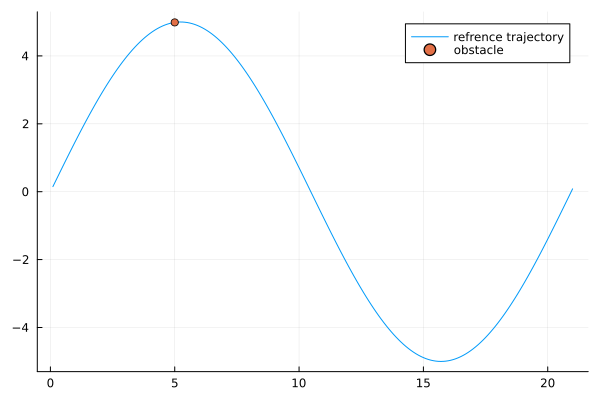

In [208]:
data = DataFrame(CSV.File("data\\Sin_Traj.csv"))
ref_traj = Matrix(data)
ref_x = ref_traj[:,1]
ref_y = ref_traj[:,2]
ref_psi = ref_traj[:,3]
ref_v = ref_traj[:,4]
N = size(data)[1]
plot(ref_x,ref_y, label="refrence trajectory")

obstacles = [ref_x[50] ref_y[50] 1]
scatter!(obstacles[:,1], obstacles[:,2] ,label="obstacle")

In [236]:
for (i,y) in enumerate(ref_y)
    if abs(y) < 0.1
        println(i)
    end
end

105
209
210


In [234]:
ref_y[210]

0.08406950242

In [153]:
function mpc_solver(state, T, dt, L, Q, R, step, u_prev, reference_trajectory, obstacles)
    
#     if step+T > size(reference_trajectory)[1]
#         T = size(reference_trajectory)[1] - step + 1
#         println("HELLO ", step, " ", T)
#     end
    
    model = Model(Ipopt.Optimizer)
    set_silent(model)
    @variable(model, x[1:T+1])
    @variable(model, y[1:T+1])
    @variable(model, psi[1:T+1])
    @variable(model, v[1:T+1])
    @variable(model, delta[1:T])
    @variable(model, a[1:T])
    
    # warm start up from previous output
    set_start_value(delta[1], u_prev[1])
    set_start_value(a[1], u_prev[2])

    #closest_refs = [find_closest_ref(x[i],y[i]) for i in 1:N]
   
    #idx = (step+i-1)%N
    @NLexpression(model, err, sum( (Q[1]*(x[i] - reference_trajectory[(step+i-1)%N + 1,1])^2 + Q[2]*(y[i] - reference_trajectory[(step+i-1)%N + 1,2])^2
                    + Q[3]*(psi[i] - reference_trajectory[(step+i-1)%N + 1,3])^2 + Q[4]*(v[i] - reference_trajectory[(step+i-1)%N + 1,4]))^2 for i in 1:T))

    @NLexpression(model, input, sum( (R[1]*delta[i]^2 + R[2]*a[i]^2) for i in 1:T))

    @NLobjective(model, Min, err + input)

    # Bicycle model constraint
    for i in 1:T-1
        @NLconstraint(model, x[i+1] == x[i] + v[i] * cos(psi[i]) * dt) 
        @NLconstraint(model, y[i+1] == y[i] + v[i] * sin(psi[i]) * dt)  
        @NLconstraint(model, psi[i+1] == psi[i] + (v[i] * tan(delta[i]) / L) * dt)
        @constraint(model, v[i+1] ==  v[i] + a[i]*dt)
        #@constraint(model, v[i+1] ==  1)
    end

    #@constraint(model, vel[i in 1:N], v)
    
    # set initial constraint
    @constraint(model, x[1]   == state[1])
    @constraint(model, y[1]   == state[2])
    @constraint(model, psi[1] == state[3])
    @constraint(model, v[1]   == state[4])
    
    # control input constraints
    @constraint(model, a_up[i in 1:T], a[i] <= 0.2)
    @constraint(model, a_lb[i in 1:T], a[i] >= -0.2)
    
    @constraint(model, delta_up[i in 1:T], delta[i] <= pi/6)
    @constraint(model, delta_lb[i in 1:T], delta[i] >= -pi/6)
    
    # obstacle constraint
    num_obstacles = size(obstacles)[1] 
    if num_obstacles > 0
        for o in 1:num_obstacles
            #@NLconstraint(model, obs_constr[i in 1:T], (x[i] - obstacles[o,1])^2 + (y[i]-obstacles[o,2])^2 >= obstacles[o,3]^2)
           for i in 1
                @NLconstraint(model, (x[i] - obstacles[o,1])^2 + (y[i]-obstacles[o,2])^2 >= obstacles[o,3]^2)
            end
        end
    end

    optimize!(model)
    return value.(delta[1]), value.(a[1]), objective_value(model)
end

mpc_solver (generic function with 1 method)

In [193]:
T = 50
dt = 0.1
L = 0.5
Q = [50.0, 50.0, 1.0, 1.0]
R = [0.1, 0.1]
initial_state = [0.0, 0.0, 0, 1.0]
num_steps = N - T

state = initial_state
state_mat =  Matrix{Float64}(undef, num_steps,4)
control_mat =  Matrix{Float64}(undef, num_steps,2)
err_vec = []
delta_prev = 0
a_prev = 0
for step in 1:num_steps
    t = step * dt
    delta, a, err = mpc_solver(state, T, dt, L, Q, R, step, [delta_prev, a_prev], ref_traj, obstacles)
    state = bicycle_model(state, [delta, a], dt, L)
    state_mat[step,:] = state
    control_mat[step,:] = [delta, a]
    append!(err_vec, err)
    delta_prev = delta
    a_prev = a
    println("Step: ", step, ", State: ", state, ", Control Input: (", delta, ", ", a, ")")
    #break
end


Step: 1, State: [0.1, 0.0, 0.11547005648241666, 1.0200000009956849], Control Input: (0.5235987855151419, 0.20000000995684994)
Step: 2, State: [0.20132075528766097, 0.011751790001948485, 0.23324951402466323, 1.0400000019620281], Control Input: (0.5235987848357662, 0.20000000966343276)
Step: 3, State: [0.30250448118818163, 0.03579037676778186, 0.3533383727336019, 1.0600000029253407], Control Input: (0.5235987845800573, 0.2000000096331251)
Step: 4, State: [0.4019560939970851, 0.0724697547849344, 0.4757366325594403, 1.0800000038852975], Control Input: (0.5235987841590835, 0.20000000959956876)
Step: 5, State: [0.4979632980608957, 0.12193304270407969, 0.6004442939569528, 1.1000000048800553], Control Input: (0.5235987853341244, 0.20000000994757822)
Step: 6, State: [0.5887226117477117, 0.18408404500057818, 0.7274613555515673, 1.1200000058321191], Control Input: (0.5235987817666964, 0.20000000952063743)
Step: 7, State: [0.6723714859343536, 0.258561329980274, 0.8567878192329894, 1.14000000682624

Step: 53, State: [5.514125511085628, 4.511398604944527, -0.4729755045259642, 1.5972236226550034], Control Input: (0.38252635213101016, -0.039578773295680096)
Step: 54, State: [5.656313037826231, 4.438639136508714, -0.3658973279760177, 1.5772279624227827], Control Input: (0.3234304705670505, -0.1999566023222065)
Step: 55, State: [5.803595071459966, 4.38220791267656, -0.29238895333656534, 1.5832696216139537], Control Input: (0.2289445080129437, 0.060416591911709866)
Step: 56, State: [5.955202323107103, 4.33657165302201, -0.10956872220970434, 1.5632696211124044], Control Input: (0.5235987819439009, -0.20000000501549206)
Step: 57, State: [6.110591847212918, 4.31947735920514, 0.07094210736023415, 1.5432696206691399], Control Input: (0.5235987810121834, -0.20000000443264532)
Step: 58, State: [6.264530625100243, 4.330416458041858, 0.24914353495616046, 1.5232696202965155], Control Input: (0.5235987790264742, -0.20000000372624496)
Step: 59, State: [6.41215433362973, 4.367976330794358, 0.4250355

Step: 105, State: [10.699859784738367, -0.34130447249674917, -0.9809342519341595, 1.7970414211821002], Control Input: (0.0026404162957240503, -0.025343763254343166)
Step: 106, State: [10.799819568655968, -0.4906417427730878, -0.9795626461678432, 1.7937064513682295], Control Input: (0.0038162701524053727, -0.03334969813870711)
Step: 107, State: [10.89979820388979, -0.6395648801076959, -0.977764393891465, 1.7897105363902641], Control Input: (0.0050126296132400935, -0.039959149779653924)
Step: 108, State: [10.999821155874548, -0.7879766286888576, -0.9755316949439528, 1.785204797072659], Control Input: (0.00623751703544016, -0.04505739317605038)
Step: 109, State: [11.09992256766478, -0.9357916111247213, -0.9728540191391893, 1.7803076007119207], Control Input: (0.007499491401080796, -0.0489719636073831)
Step: 110, State: [11.200143736485966, -1.0829332736531903, -0.9697181875860125, 1.7750087523362899], Control Input: (0.008806765978861859, -0.05298848375630949)
Step: 111, State: [11.300526

Step: 157, State: [15.892805210794956, -5.008220612410055, 0.13039880324516734, 0.9774704903646633], Control Input: (0.2449760168826996, 0.08866473895946017)
Step: 158, State: [15.989722398757815, -4.995510605615834, 0.1747334413608222, 0.991799189991865], Control Input: (0.22301039186298277, 0.1432869962720177)
Step: 159, State: [16.087392096595817, -4.978268608721086, 0.21537097804438668, 1.0112013818346715], Control Input: (0.20207169167061928, 0.19402191842806507)
Step: 160, State: [16.18617607440509, -4.9566582391170995, 0.25342525479428607, 1.031024457331398], Control Input: (0.18598902281785806, 0.19823075496726572)


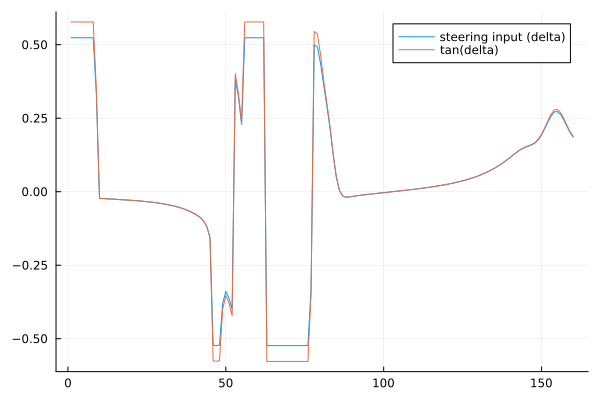

In [194]:
plot(1:num_steps, [control_mat[:,1], tan.(control_mat[:,1])], label=["steering input (delta)" "tan(delta)"])

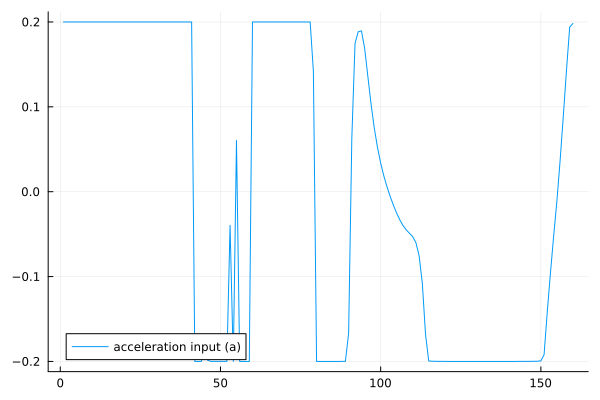

In [195]:
plot(1:num_steps, control_mat[:,2], label="acceleration input (a)")

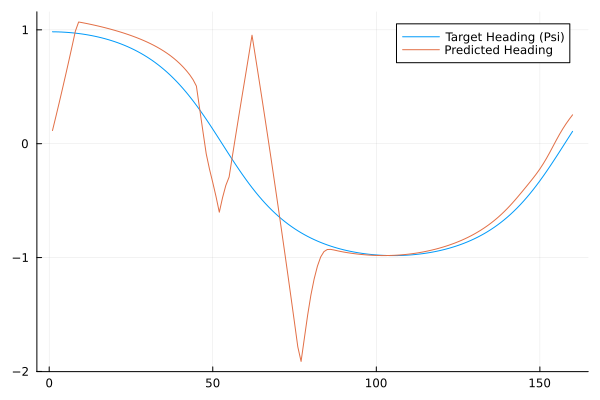

In [196]:
plot(1:num_steps, [ref_psi[1:num_steps],state_mat[:,3]], label=["Target Heading (Psi)" "Predicted Heading"])

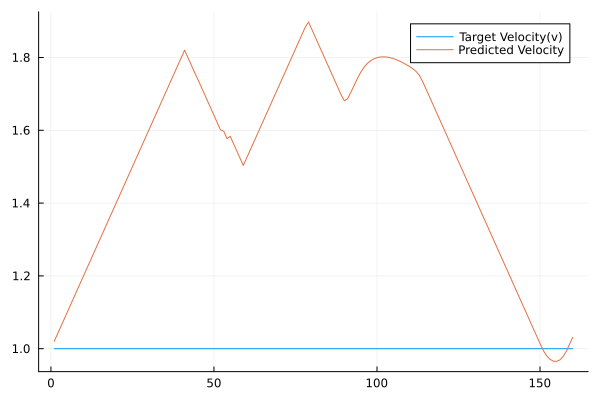

In [197]:
plot(1:num_steps, [ref_v[1:num_steps],state_mat[:,4]], label=["Target Velocity(v)" "Predicted Velocity"])

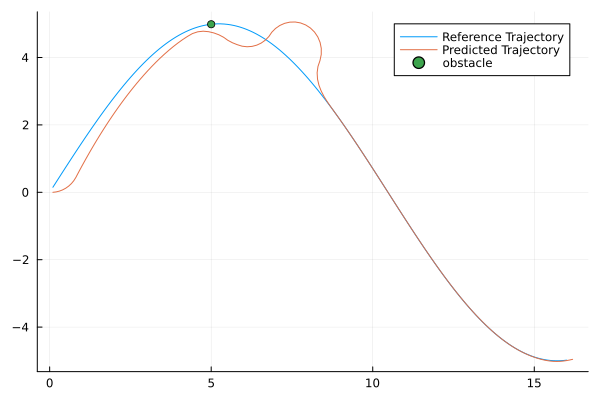

In [198]:
x = state_mat[:,1]
y = state_mat[:,2]
plot(ref_x[1:num_steps], ref_y[1:num_steps], label="Reference Trajectory")
plot!(x,y, label="Predicted Trajectory")
scatter!(obstacles[:,1], obstacles[:,2],label="obstacle")

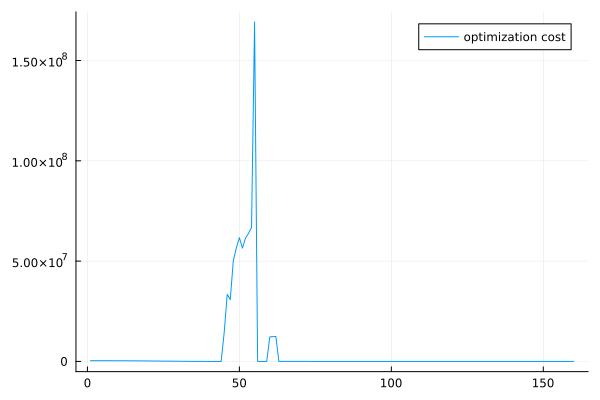

In [199]:
plot(1:num_steps, err_vec, label = "optimization cost")

In [27]:
ref_x

1000-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 ⋮
 9.88
 9.89
 9.9
 9.91
 9.92
 9.93
 9.94
 9.95
 9.96
 9.97
 9.98
 9.99

In [86]:
400*0.01

4.0